<a href="https://colab.research.google.com/github/Leon-web-net/ES327_Project/blob/main/YOLO_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Directory/albumentations/Config_list

In [2]:
import os
# Change to a new directory
new_directory = '/content/drive/MyDrive/YOLOV3_Pytorch/'
os.chdir(new_directory)

# Confirm the changey
print("New working directory:", os.getcwd())

New working directory: /content/drive/MyDrive/YOLOV3_Pytorch


# Pascal Voc to Yolo

In [ ]:
# import os

# HEIGHT = 900
# WIDTH = 1600

# dataset_path = "/content/drive/MyDrive/datasets/Nuim_dataset"
# os.makedirs(dataset_path + "/labels_yolo", exist_ok=True)
# label_path = dataset_path + "/labels"
# yolo_label_path = dataset_path + "/labels_yolo"

# label_list = os.listdir(label_path)
# labels_num = len(label_list)
# print(labels_num)
# i = 0
# for label_file in label_list:

#     with open(os.path.join(label_path, label_file), "r") as file:
#         lines = file.readlines()

#     yolo_labels = []
#     for line in lines:
#         values = line.strip().split()
#         class_id = int(values[0])
#         x1, y1, x2, y2 = map(float, values[1:])

#         # Convert from Pascal VOC to YOLO format
#         x_center = (x1 + x2) / 2 / WIDTH
#         y_center = (y1 + y2) / 2 / HEIGHT
#         width = (x2 - x1) / WIDTH
#         height = (y2 - y1) / HEIGHT

#         # Format the YOLO label
#         yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

#     # Save the YOLO labels to a new file in the labels_yolo directory
#     with open(os.path.join(yolo_label_path, label_file), "w") as file:
#         file.write("\n".join(yolo_labels))

# print(f"Converted {labels_num} label files to YOLO format.")

6000
Converted 6000 label files to YOLO format.


# Class Instances

In [ ]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
import tqdm

# Define your class names
class_names = [
    "pedestrian",
    "movable_object",
    "car",
    "bus",
    "bicycle",
    "truck",
    "motorcycle",
    "construction",
]

# Function to count class instances from a list of label files
def process_label_file(label_path):
    class_counts = {class_name: 0 for class_name in class_names}

    try:
        with open(label_path, "r") as file:
            lines = file.readlines()
            for line in lines:
                class_idx = int(line.split()[0])
                class_name = class_names[class_idx]
                class_counts[class_name] += 1
    except Exception as e:
        print(f"Error reading {label_path}: {e}")

    return class_counts

# Function to aggregate counts from all label files
def count_class_instances(csv_path, label_dir, num_threads=8):
    df = pd.read_csv(csv_path)
    label_paths = [os.path.join(label_dir, path) for path in df["label_path"]]

    # Initialize class counts
    total_counts = {class_name: 0 for class_name in class_names}

    # Use multithreading to process files in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm.tqdm(executor.map(process_label_file, label_paths), total=len(label_paths)))

    # Aggregate the counts
    for result in results:
        for class_name, count in result.items():
            total_counts[class_name] += count

    return total_counts

# Paths to your train.csv and test.csv
dataset_path = "/content/drive/MyDrive/datasets/Nuim_dataset"
train_csv_path = os.path.join(dataset_path, "train.csv")
test_csv_path = os.path.join(dataset_path, "test.csv")
label_dir = os.path.join(dataset_path, "labels")

# Count class instances
train_class_counts = count_class_instances(train_csv_path, label_dir)
test_class_counts = count_class_instances(test_csv_path, label_dir)

# Print the results
print("\nClass Instances in Train Dataset:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

print("\nClass Instances in Test Dataset:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")


100%|██████████| 1200/1200 [00:46<00:00, 25.59it/s]


Class Instances in Train Dataset:
pedestrian: 11151
movable_object: 11449
car: 16276
bus: 532
bicycle: 1255
truck: 2393
motorcycle: 1033
construction: 384

Class Instances in Test Dataset:
pedestrian: 2508
movable_object: 2712
car: 3920
bus: 138
bicycle: 292
truck: 573
motorcycle: 294
construction: 92


# Anchor boxes K means cluster

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
import tqdm

# Define image size (same as used in your training)
IMAGE_SIZE = 416


In [ ]:
def load_bbox_dimensions(label_dir):
    bbox_dims = []

    # Iterate through all label files
    for label_file in tqdm.tqdm(os.listdir(label_dir)):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            for line in f.readlines():
                # YOLO format: class_idx, x_center, y_center, width, height
                _, _, _, width, height = map(float, line.strip().split())
                bbox_dims.append([width * IMAGE_SIZE, height * IMAGE_SIZE])  # Scale to image size

    return np.array(bbox_dims)


In [ ]:
def run_kmeans(bbox_dims, n_clusters=9):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    kmeans.fit(bbox_dims)

    # Get the resulting anchor boxes
    anchors = kmeans.cluster_centers_
    anchors = np.array(anchors, dtype=np.float32)

    # Sort anchors by area (width * height) for consistency
    anchors = anchors[np.argsort(anchors[:, 0] * anchors[:, 1])]

    return anchors

def normalize_anchors(anchors, image_size):
    normalized_anchors = anchors / image_size
    return normalized_anchors

In [ ]:
# Set paths
LABEL_DIR = "/content/drive/MyDrive/datasets/Nuim_dataset/labels"

# Load bounding box dimensions
bbox_dims = load_bbox_dimensions(LABEL_DIR)

# Run K-means clustering to find anchor boxes
optimized_anchors = run_kmeans(bbox_dims, n_clusters=9)

# Normalize the anchor boxes
normalized_anchors = normalize_anchors(optimized_anchors, IMAGE_SIZE)

# Print the optimized anchor boxes
print("Optimized Anchor Boxes (YOLO format):")
for anchor in normalized_anchors:
    print(f"[{anchor[0]:.4f}, {anchor[1]:.4f}]")


100%|██████████| 6000/6000 [01:17<00:00, 77.65it/s] 


Optimized Anchor Boxes (YOLO format):
[0.0208, 0.0396]
[0.0340, 0.1151]
[0.0763, 0.0706]
[0.0773, 0.2487]
[0.1514, 0.1406]
[0.2713, 0.2756]
[0.2171, 0.4931]
[0.6019, 0.4547]
[0.7280, 0.8929]


In [ ]:
normalized_anchors

array([[0.02075368, 0.03960799],
       [0.03395113, 0.1150809 ],
       [0.07630085, 0.07060258],
       [0.07728364, 0.2486714 ],
       [0.15140891, 0.1405775 ],
       [0.27132374, 0.2756058 ],
       [0.21706615, 0.49310425],
       [0.6019261 , 0.45473444],
       [0.728     , 0.8928778 ]], dtype=float32)

# Albumentation Edit

In [3]:
!pip install albumentations==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
import config

config.DEVICE

/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


'cpu'

In [ ]:
import shutil


# Replace the file from Google Drive
src = "/content/drive/MyDrive/YOLOV3_Pytorch/bbox_utils.py"
dst = "/usr/local/lib/python3.10/dist-packages/albumentations/core/bbox_utils.py"

shutil.copy(src, dst)
print("File replaced successfully!")


File replaced successfully!


In [3]:
"""
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride)
Every conv is a same convolution.
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""

config_list = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

# Model

In [4]:
import torch
import torch.nn as nn
import config

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.leaky = nn.LeakyReLU(0.1)
    self.use_bn_act = bn_act


  def forward(self, x):
    if self.use_bn_act:
      return self.leaky(self.bn(self.conv(x)))
    else:
      return self.conv(x)

class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
    super().__init__()
    self.layers = nn.ModuleList()
    for repeat in range(num_repeats):
      self.layers +=[
          nn.Sequential(
          CNNBlock(channels, channels//2, kernel_size=1),
          CNNBlock(channels//2, channels, kernel_size=3, padding=1),
          )
      ]
      self.use_residual = use_residual
      self.num_repeats = num_repeats

  def forward(self, x):
    for layer in self.layers:
      x = layer(x) + x if self.use_residual else layer(x)
    return x

class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.pred = nn.Sequential(
        CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
        CNNBlock(2*in_channels, 3*(5+num_classes), bn_act=False, kernel_size=1),  # [po, x, y, w, h]
    )

    self.num_classes = num_classes

  def forward(self,x):
    return(
        self.pred(x).reshape(
            x.shape[0],3, self.num_classes+5, x.shape[2], x.shape[3]
        ).permute(0,1,3,4,2)  # change order
    )

class YOLOv3(nn.Module):

  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_conv_layers()

  def forward(self,x):
    outputs = []
    route_connections = []

    for layer in self.layers:
      if isinstance(layer, ScalePrediction):
        outputs.append(layer(x))
        continue
      x = layer(x)

      if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
        route_connections.append(x)

      elif isinstance(layer, nn.Upsample):
        x = torch.cat([x, route_connections[-1]], dim=1)
        route_connections.pop()

    return outputs

  def _create_conv_layers(self):
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config_list:
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(CNNBlock(
            in_channels,
            out_channels,
            kernel_size = kernel_size,
            stride = stride,
            padding = 1 if kernel_size == 3 else 0,
        ))
        in_channels = out_channels

      elif isinstance(module, list):
        num_repeats = module[1]
        layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

      elif isinstance(module, str):
        if module == "S":
          layers+=[
              ResidualBlock(in_channels, use_residual=False, num_repeats=1),
              CNNBlock(in_channels, in_channels//2, kernel_size=1),
              ScalePrediction(in_channels//2, num_classes=self.num_classes),
          ]

          in_channels = in_channels // 2

        elif module == "U":
          layers.append(nn.Upsample(scale_factor=2),)
          in_channels = in_channels * 3

    return layers


if __name__ == "__main__":
  num_classes = config.NUM_CLASSES
  IMAGE_SIZE = 416
  model = YOLOv3(num_classes=num_classes)
  x = torch.randn((2,3,IMAGE_SIZE,IMAGE_SIZE))
  out = model(x)
  assert model(x)[0].shape == (2,3,IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes+5)
  assert model(x)[1].shape == (2,3,IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes+5)
  assert model(x)[2].shape == (2,3,IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes+5)
  print("Success!")


Success!


## Imports

In [5]:
import numpy as np
import os
import pandas as pd
import torch

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import iou_width_height, intersection_over_union, non_max_suppression


# Dataset Loader

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Loss Function

In [7]:
import torch
import torch.nn as nn

from utils import intersection_over_union

class YoloLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
    self.bce = nn.BCEWithLogitsLoss()
    self.entropy = nn.CrossEntropyLoss()
    self.sigmoid = nn.Sigmoid()

    # Constants
    self.lambda_class = 1
    self.lambda_noobj = 10
    self.lambda_obj = 1
    self.lambda_box = 10


  def forward(self, predictions, target, anchors):
    obj = target[...,0] == 1
    noobj = target[...,0] == 0

    # No object loss
    no_object_loss = self.bce(
        (predictions[...,0:1][noobj]), (target[...,0:1][noobj]),
    )

    # Object Loss
    anchors = anchors.reshape(1,3,1,1,2)
    box_preds = torch.cat([self.sigmoid(predictions[...,1:3]), torch.exp(predictions[...,3:5])*anchors], dim=-1)
    ious = intersection_over_union(box_preds[obj], target[...,1:5][obj]).detach()
    object_loss = self.bce((predictions[...,0:1][obj]),(ious*target[...,0:1][obj]))

    # Box Coordinate Loss
    predictions[...,1:3] = self.sigmoid(predictions[...,1:3]) # x,y to be [0,1]
    target[...,3:5] = torch.log(
        (1e-16 + target[...,3:5] / anchors) # avoid torch log of 0 (changed from -16 -> -16)
    )
    box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

    # Class Loss
    class_loss = self.entropy(
        (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
    ) # check class label

    return (
        self.lambda_box*box_loss
        +self.lambda_obj*object_loss
        +self.lambda_noobj*no_object_loss
        +self.lambda_class*class_loss
    )


# Train

In [8]:
import config
import torch
import torch.optim as optim
import tqdm

from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples,
)

torch.backends.cudnn.benchmark = True

In [9]:
import importlib, Test_module, utils,dataset,config
importlib.reload(Test_module)
importlib.reload(utils)
from Test_module import test_fn
importlib.reload(config)
test_fn()

Hi config working? batch size


In [11]:
import pandas as pd


def train_fn(train_loader,model,optimizer,loss_fn,scaler, scaled_anchors):
  loop = tqdm.tqdm(train_loader, leave=True)
  losses = []
  # print(f"\n\n\nB4 FOR LOOP\n\n\n")
  for batch_idx, (x,y) in enumerate(loop):

    x = x.to(config.DEVICE)
    y0,y1,y2 = (
        y[0].to(config.DEVICE),
        y[1].to(config.DEVICE),
        y[2].to(config.DEVICE),
    )

    # print(F"\n\n\nPAST FOR LOOP\n\n\n")

    with torch.cuda.amp.autocast(): # float 16 pytorch
      out = model(x)
      loss = (
          loss_fn(out[0], y0, scaled_anchors[0])
          + loss_fn(out[1], y1, scaled_anchors[1])
          + loss_fn(out[2], y2, scaled_anchors[2])
      )

    losses.append(loss.item())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update progress bar
    mean_loss = sum(losses)/len(losses)
    loop.set_postfix(loss=mean_loss)

def main():
  model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
  optimizer = optim.Adam(
      model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
  )

  loss_fn = YoloLoss()
  scaler = torch.amp.GradScaler()

  train_loader, test_loader = get_loaders(
      train_csv_path=config.DATASET + "/train.csv",
      test_csv_path=config.DATASET + "/test.csv",)


  if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_LOAD_FILE, model, optimizer, config.LEARNING_RATE
  )
  scaled_anchors = (
        torch.tensor(config.ANCHORS)
        * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
    ).to(config.DEVICE)

  for epoch in range(config.NUM_EPOCHS):
    print(f"epoch NO. {epoch}")
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    # if config.SAVE_MODEL:
    #   save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

    # print(f"Currently epoch {epoch}")
    # print("On Train Eval loader:")
    # print("On Train loader:")


    if (epoch+1) % 5 == 0 and epoch> 0:
    # if epoch>-1:
      # print(f"Epoch: {epoch}, checking class accuracy")
      last_train_epoch = 49
      check_class_accuracy(model, test_loader,epoch+last_train_epoch, threshold=config.CONF_THRESHOLD)
      # print("Finished Checking class accuracy")
      pred_boxes, true_boxes = get_evaluation_bboxes(
          test_loader,
          model,
          iou_threshold=config.NMS_IOU_THRESH,
          anchors=config.ANCHORS,
          threshold=config.CONF_THRESHOLD,
      )
      mapval = mean_average_precision(
          pred_boxes,
          true_boxes,
          iou_threshold=config.MAP_IOU_THRESH,
          box_format="midpoint",
          num_classes=config.NUM_CLASSES,
      )
      # Path to your existing evaluation results CSV
      eval_results_path = f"{config.EVAL_PATH}/Eval_results.csv"

      # Load the existing CSV
      existing_df = pd.read_csv(eval_results_path)

      # Add a new column for mAP with the current mapval
      existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"

      # Save the updated CSV back to the same file
      existing_df.to_csv(eval_results_path, index=False)


      print(f"MAP: {mapval.item()}")
      model.train()

    if config.SAVE_MODEL:
      save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

if __name__ == "__main__":
  print(f"Config conf threshold : {config.CONF_THRESHOLD}")

  main()


print("Trianing Complete")

Config conf threshold : 0.5
=> Loading checkpoint


/content/drive/MyDrive/YOLOV3_Pytorch/utils.py:533: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)


epoch NO. 0


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [25:42<00:00,  5.14s/it, loss=6.68]


=> Saving checkpoint
epoch NO. 1


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.66]


=> Saving checkpoint
epoch NO. 2


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.66]


=> Saving checkpoint
epoch NO. 3


100%|██████████| 300/300 [03:15<00:00,  1.54it/s, loss=6.6]


=> Saving checkpoint
epoch NO. 4


100%|██████████| 75/75 [03:14<00:00,  2.60s/it]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     53    79.10%  79.94%   78.74%      79.937378          99.716461   

  Object Accuracy  
0       32.551617  


100%|██████████| 75/75 [01:13<00:00,  1.03it/s]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.215785' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.21578483283519745
=> Saving checkpoint
epoch NO. 5


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:16<00:00,  1.52it/s, loss=6.54]


=> Saving checkpoint
epoch NO. 6


100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=6.51]


=> Saving checkpoint
epoch NO. 7


100%|██████████| 300/300 [03:16<00:00,  1.52it/s, loss=6.43]


=> Saving checkpoint
epoch NO. 8


100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=6.38]


=> Saving checkpoint
epoch NO. 9


100%|██████████| 75/75 [00:37<00:00,  1.97it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     58    79.45%  80.56%   79.29%      80.560356          99.763397   

  Object Accuracy  
0       32.695129  


100%|██████████| 75/75 [01:14<00:00,  1.00it/s]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.234778' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.23477844893932343
=> Saving checkpoint
epoch NO. 10


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.32]


=> Saving checkpoint
epoch NO. 11


100%|██████████| 300/300 [03:14<00:00,  1.55it/s, loss=6.32]


=> Saving checkpoint
epoch NO. 12


100%|██████████| 300/300 [03:14<00:00,  1.55it/s, loss=6.31]


=> Saving checkpoint
epoch NO. 13


100%|██████████| 300/300 [03:15<00:00,  1.54it/s, loss=6.25]


=> Saving checkpoint
epoch NO. 14


100%|██████████| 75/75 [00:37<00:00,  1.98it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     63    79.79%  80.26%   79.36%      80.260284          99.687691   

  Object Accuracy  
0       35.624123  


100%|██████████| 75/75 [01:16<00:00,  1.02s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.239801' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.23980124294757843
=> Saving checkpoint
epoch NO. 15


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.17]


=> Saving checkpoint
epoch NO. 16


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.2]


=> Saving checkpoint
epoch NO. 17


100%|██████████| 300/300 [03:08<00:00,  1.59it/s, loss=6.13]


=> Saving checkpoint
epoch NO. 18


100%|██████████| 300/300 [03:12<00:00,  1.56it/s, loss=6.17]


=> Saving checkpoint
epoch NO. 19


100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     68    80.22%  80.77%   79.92%      80.765846          99.709152   

  Object Accuracy  
0       35.682835  


100%|██████████| 75/75 [01:17<00:00,  1.03s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.256261' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.25626108050346375
=> Saving checkpoint
epoch NO. 20


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:14<00:00,  1.55it/s, loss=5.99]


=> Saving checkpoint
epoch NO. 21


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=6.04]


=> Saving checkpoint
epoch NO. 22


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, loss=5.98]


=> Saving checkpoint
epoch NO. 23


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=5.91]


=> Saving checkpoint
epoch NO. 24


100%|██████████| 75/75 [00:39<00:00,  1.89it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     73    80.43%  80.80%   79.92%      80.795197          99.651794   

  Object Accuracy  
0       35.803516  


100%|██████████| 75/75 [01:17<00:00,  1.03s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.253290' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.2532902956008911
=> Saving checkpoint
epoch NO. 25


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:12<00:00,  1.56it/s, loss=5.99]


=> Saving checkpoint
epoch NO. 26


100%|██████████| 300/300 [03:16<00:00,  1.53it/s, loss=5.96]


=> Saving checkpoint
epoch NO. 27


100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=5.92]


=> Saving checkpoint
epoch NO. 28


100%|██████████| 300/300 [03:24<00:00,  1.47it/s, loss=5.88]


=> Saving checkpoint
epoch NO. 29


100%|██████████| 75/75 [00:39<00:00,  1.91it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     78    80.75%  81.31%   80.39%      81.310547          99.691650   

  Object Accuracy  
0       37.356079  


100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.260159' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.26015913486480713
=> Saving checkpoint
epoch NO. 30


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=5.75]


=> Saving checkpoint
epoch NO. 31


100%|██████████| 300/300 [03:16<00:00,  1.52it/s, loss=5.82]


=> Saving checkpoint
epoch NO. 32


100%|██████████| 300/300 [03:18<00:00,  1.51it/s, loss=5.83]


=> Saving checkpoint
epoch NO. 33


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=5.7]


=> Saving checkpoint
epoch NO. 34


100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     83    80.46%  81.19%   80.52%      81.193123          99.663994   

  Object Accuracy  
0       37.290844  


100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.269101' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.2691008448600769
=> Saving checkpoint
epoch NO. 35


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:19<00:00,  1.51it/s, loss=5.69]


=> Saving checkpoint
epoch NO. 36


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, loss=5.67]


=> Saving checkpoint
epoch NO. 37


100%|██████████| 300/300 [03:16<00:00,  1.53it/s, loss=5.65]


=> Saving checkpoint
epoch NO. 38


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, loss=5.61]


=> Saving checkpoint
epoch NO. 39


100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     88    80.87%  81.22%   80.18%      81.219223          99.662994   

  Object Accuracy  
0       38.452003  


100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.266580' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.2665797173976898
=> Saving checkpoint
epoch NO. 40


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=5.61]


=> Saving checkpoint
epoch NO. 41


100%|██████████| 300/300 [03:16<00:00,  1.53it/s, loss=5.65]


=> Saving checkpoint
epoch NO. 42


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, loss=5.57]


=> Saving checkpoint
epoch NO. 43


100%|██████████| 300/300 [03:15<00:00,  1.54it/s, loss=5.54]


=> Saving checkpoint
epoch NO. 44


100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     93    81.25%  81.83%   81.01%      81.829155          99.703476   

  Object Accuracy  
0       36.693958  


100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.281165' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.28116539120674133
=> Saving checkpoint
epoch NO. 45


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-11-edea0badae10>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # float 16 pytorch
100%|██████████| 300/300 [03:16<00:00,  1.53it/s, loss=5.44]


=> Saving checkpoint
epoch NO. 46


100%|██████████| 300/300 [03:18<00:00,  1.51it/s, loss=5.45]


=> Saving checkpoint
epoch NO. 47


100%|██████████| 300/300 [03:17<00:00,  1.52it/s, loss=5.55]


=> Saving checkpoint
epoch NO. 48


100%|██████████| 300/300 [03:18<00:00,  1.51it/s, loss=5.46]


=> Saving checkpoint
epoch NO. 49


100%|██████████| 75/75 [00:41<00:00,  1.83it/s]


   Epoch Precision  Recall F1 Score Class Accuracy No Object Accuracy  \
0     98    81.14%  81.67%   81.01%      81.669327          99.694077   

  Object Accuracy  
0       39.104343  


100%|██████████| 75/75 [01:20<00:00,  1.07s/it]
<ipython-input-11-edea0badae10>:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.259092' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  existing_df.loc[existing_df.index[-1], 'mAP'] = f"{mapval.item():.6f}"


MAP: 0.25909167528152466
=> Saving checkpoint
Trianing Complete


In [ ]:
importlib.reload(dataset)
importlib.reload(config)

<module 'config' from '/content/drive/MyDrive/YOLOV3_Pytorch/config.py'>

# Test

In [ ]:
csv_file = "/content/drive/MyDrive/datasets/YOLOV3_nuim/train.csv"
annotations = pd.read_csv(csv_file)
dataset_dir = '/content/drive/MyDrive/datasets/YOLOV3_nuim'
img_dir =  dataset_dir + '/images/'
label_dir = dataset_dir + "/labels/"

index = 14
img_path = os.path.join(img_dir, annotations.iloc[index, 0])
label_path = os.path.join(label_dir, annotations.iloc[index, 1])

bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()

img_path

'/content/drive/MyDrive/datasets/YOLOV3_nuim/images/00000031.jpg'

In [ ]:
# [x y w h class]
bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
img_path = os.path.join(img_dir, annotations.iloc[index, 0])
image = np.array(Image.open(img_path).convert("RGB"))
image.shape
targets = [torch.zeros((3, S, S, 6)) for S in config.S]
anchors = config.ANCHORS
anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
boxes = []
box = bboxes[0]

iou_anchors = iou_width_height(torch.tensor(box[2:4]), anchors)
anchor_indices = iou_anchors.argsort(descending=True, dim=0)
x, y, width, height, class_label = box
has_anchor = [False,False, False]

num_anchors = anchors.shape[0]
num_anchors_per_scale = num_anchors // 3
S = config.S

x,y,width,height

(0.73344, 0.57056, 0.15687, 0.20333)

In [ ]:
import importlib
from albumentations.core import bbox_utils

# Force reload of the module
importlib.reload(bbox_utils)

<module 'albumentations.core.bbox_utils' from '/usr/local/lib/python3.10/dist-packages/albumentations/core/bbox_utils.py'>

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

 # Example bbox: [x_center, y_center, width, height]
image = np.array(Image.open(img_path).convert("RGB"))
bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()

# Transformation pipeline
transform = A.Compose(
    [
        A.Resize(height=416, width=416),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),

)

# Apply transformations
transformed = transform(image=image, bboxes=bboxes)
bboxes_0 = transformed["bboxes"]
# Convert list of tuples to NumPy array for efficient processing
bboxes_clip = np.array(bboxes_0)
# Clip x_center, y_center, width, height to [np.finfo(np.float32).tiny, 1.0]
bboxes_clip[:, :4] = np.clip(bboxes_clip[:, :4], np.finfo(np.float16).tiny, 1.0)

print("Original BBoxes:", bboxes)
print("Transformed BBoxes:", transformed["bboxes"])
print("Clipped: ", bboxes_clip)

Original BBoxes: [[0.73344, 0.57056, 0.15687, 0.20333, 4.0], [0.48219, 0.46056, 0.01188, 0.01667, 4.0], [0.24969, 0.49111, 0.08188, 0.04889, 4.0], [0.44188, 0.47778, 0.0275, 0.04444, 4.0], [0.555, 0.47667, 0.02, 0.03111, 4.0], [0.45469, 0.47, 0.01438, 0.02222, 4.0], [0.02937, 0.70389, 0.05875, 0.29, 4.0], [0.84562, 0.49833, 0.14125, 0.09222, 9.0], [0.91969, 0.61167, 0.16062, 0.37222, 4.0], [0.44844, 0.45667, 0.01562, 0.02, 4.0], [0.53406, 0.45667, 0.09813, 0.05556, 9.0], [0.52625, 0.47167, 0.02125, 0.03222, 4.0]]
Transformed BBoxes: [[0.7334399819374084, 0.5705599784851074, 0.1568700075149536, 0.20333001017570496, 4.0], [0.48219001293182373, 0.46055999398231506, 0.011879980564117432, 0.01666998863220215, 4.0], [0.2496899962425232, 0.49111002683639526, 0.08187998831272125, 0.04889002442359924, 4.0], [0.4418799877166748, 0.4777800142765045, 0.0274999737739563, 0.04443997144699097, 4.0], [0.5550000071525574, 0.4766699969768524, 0.019999980926513672, 0.031109988689422607, 4.0], [0.45469000

In [ ]:
import os
import numpy as np
import torch


num_anchors_per_scale = 3  # Adjust based on your model
anchors = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]])  # Example anchor dimensions


def validate_box_coordinates(label_dir, annotations):
    for index in range(len(annotations)):
            # Load bounding boxes for the current index
            label_path = os.path.join(label_dir, annotations.iloc[index, 1])
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
            img_path = os.path.join(img_dir, annotations.iloc[index, 0])
            image = np.array(Image.open(img_path).convert("RGB"))
            for box in bboxes:
                x, y, width, height, class_id = box[:5]
                iou_anchors = iou_width_height(torch.tensor(box[2:4]), anchors)
                anchor_indices = iou_anchors.argsort(descending=True, dim=0)
                has_anchor = [False, False, False]

                for anchor_idx in anchor_indices:
                    # Calculate scale and anchor indices
                    scale_idx = anchor_idx // num_anchors_per_scale
                    anchor_on_scale = anchor_idx % num_anchors_per_scale
                    S_0 = S[scale_idx]
                    i, j = int(S_0 * y), int(S_0 * x)
                    anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                    if not anchor_taken and not has_anchor[scale_idx]:
                        targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                        x_cell, y_cell = S_0 * x - j, S_0 * y - i
                        width_cell, height_cell = width * S_0, height * S_0

                        # Create box coordinates tensor
                        box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

                        targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                        targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                        has_anchor[scale_idx] = True
                        print(targets[scale_idx][anchor_on_scale, i, j, 1:5])
                    elif not anchor_taken and iou_anchors[anchor_idx] > 0.5:
                        targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction


    return image, tuple(targets)

# Run the validation
hello = validate_box_coordinates(label_dir, annotations)


# Try load checkpoint + Visualise

In [12]:
import torch
from utils import load_checkpoint
from config import DEVICE, IMAGE_SIZE
 # Replace with your model's class

# Initialize the model
model = YOLOv3(num_classes=8).to(DEVICE)  # Adjust num_classes based on your config

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/YOLOV3_Pytorch/checkpoint_P2_100.pth.tar"

checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()
# load_checkpoint(checkpoint_path, model, optimizer=None, lr=0)  # optimizer is optional
# model.eval()

<ipython-input-12-bb3e79c2e6e8>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))


YOLOv3(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [13]:
from utils import cells_to_bboxes, non_max_suppression

def get_single_image_bboxes(model, image, anchors, iou_threshold=0.5, conf_threshold=0.5, device="cuda"):
    model.eval()
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        predictions = model(image)

    bboxes = []
    for i in range(3):  # For each scale
        S = predictions[i].shape[2]
        anchor = torch.tensor(anchors[i]).to(device) * S
        boxes_scale_i = cells_to_bboxes(predictions[i], anchor, S=S, is_preds=True)
        bboxes += boxes_scale_i[0]  # Get the boxes for the first image in the batch

    # Apply NMS
    final_boxes = non_max_suppression(bboxes, iou_threshold=iou_threshold, threshold=conf_threshold, box_format="midpoint")

    return final_boxes


In [14]:
classes = config.MY_CLASSES
import cv2
import matplotlib.pyplot as plt

# Function to draw bounding boxes on the image
def draw_bboxes(image, bboxes, class_names):
    for bbox in bboxes:
        class_id,confidence, x_center, y_center, width, height = bbox

        # Convert YOLO midpoint format (x_center, y_center, width, height) to top-left format (x_min, y_min)
        img_h, img_w, _ = image.shape
        x_min = int((x_center - width / 2) * img_w)
        y_min = int((y_center - height / 2) * img_h)
        box_width = int(width * img_w)
        box_height = int(height * img_h)

        # Draw the rectangle
        cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 0), 2)

        # Add label
        label = f"{class_names[int(class_id)]}: {confidence:.2f}"
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image using Matplotlib
    plt.imshow(image)
    plt.axis("off")
    plt.show()




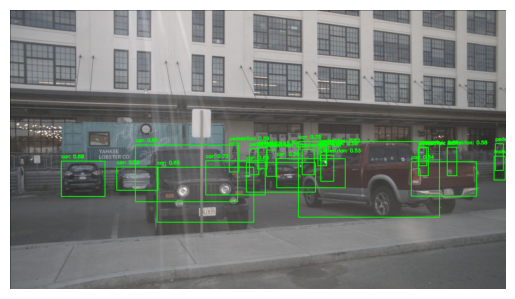

In [16]:
import cv2
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
import os
import albumentations as A

# Define preprocessing pipeline
preprocess = A.Compose([
    A.Resize(height=config.IMAGE_SIZE, width=config.IMAGE_SIZE),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
    ToTensorV2(),
])


image_dataset = "/content/drive/MyDrive/datasets/Nuim_dataset/images"
# list_of_images = os.listdir(image_dataset)
image_name = "00000908.jpg"
# Load and preprocess the image
image_path = image_dataset + "/" + image_name
image = cv2.imread(image_path)
# print(type(image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = preprocess(image=image)
image_tensor = augmented["image"]

# Example usage
image_tensor = image_tensor  # Your preprocessed image tensor
anchors = config.ANCHORS

bboxes = get_single_image_bboxes(model, image_tensor, anchors)
# Example usage
draw_bboxes(image, bboxes, config.MY_CLASSES)
